In [1]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import diverging_palette

import sklearn
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

from sklearn.linear_model import (
    LogisticRegression,
    Lasso
)

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    RepeatedStratifiedKFold,
    GridSearchCV,
    KFold
)

from sklearn.metrics import (
    accuracy_score, 
    precision_score, average_precision_score,
    precision_recall_curve,
    confusion_matrix, plot_confusion_matrix,
    roc_curve, roc_auc_score,
    classification_report
)

import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance

from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=ConvergenceWarning)

# Load Dataset into DataFrame

In [2]:
url = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/Airline-Passenger-Satisfaction-Prediction/main/Data/df5.csv'
data = pd.read_csv(url)
data

,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,...,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
0,26.0,0.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,...,3.0,4.0,4.0,4.0,5.0,0.0,1.0,0.0,1.0,1.0
1,61.0,0.0,214.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,...,4.0,4.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0
2,47.0,2.0,1276.0,2.0,4.0,2.0,3.0,2.0,2.0,2.0,...,3.0,4.0,3.0,5.0,2.0,9.0,0.0,1.0,1.0,0.0
3,52.0,0.0,2035.0,4.0,3.0,4.0,4.0,5.0,5.0,5.0,...,5.0,5.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,1.0
4,20.0,2.0,1061.0,3.0,3.0,3.0,4.0,2.0,3.0,3.0,...,3.0,4.0,4.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43954,26.0,0.0,712.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,...,4.0,4.0,3.0,4.0,5.0,17.0,1.0,1.0,1.0,1.0
43955,57.0,2.0,867.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0,...,4.0,3.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,1.0
43956,60.0,0.0,1599.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,...,4.0,4.0,4.0,4.0,4.0,9.0,1.0,0.0,1.0,1.0
43957,50.0,2.0,1620.0,3.0,1.0,3.0,4.0,2.0,3.0,2.0,...,3.0,4.0,2.0,4.0,2.0,0.0,0.0,1.0,1.0,0.0


# Data Preparation

## Standardization of numeric variables

In [3]:
numeric_cols = ['Age', 'Flight_Distance','Departure_Delay_in_Minutes']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

## Handling Missing values

The satisfaction level of each feature should range from 1 to 5. 

If the rating is 0, that means the customer did not rate for this feature.


In [4]:
def list_column_values(df, number_of_values, print_all):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() <= number_of_values:
            print(f"{col.ljust(25)}" +  ' ==> ' + str(df[col].sort_values().unique().tolist()) )
        else:  
            if print_all=='True':
               print(f"{col.ljust(25)}" + ' ==> more than ' + str(number_of_values) + ' values')

In [5]:
list_column_values(data, data.shape[1],'True')

**Results:**

Age                       ==> more than 22 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 22 values
Inflight_wifi_service     ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Departure/Arrival_time_convenient ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Ease_of_Online_booking    ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure_Delay_in_Minutes ==> more t

In [6]:
incomplete = ['Inflight_wifi_service','Departure/Arrival_time_convenient',
              'Ease_of_Online_booking','Online_boarding','Leg_room_service']
(data[incomplete] == 0).sum()

Inflight_wifi_service                 67
Departure/Arrival_time_convenient    134
Ease_of_Online_booking                58
Online_boarding                       16
Leg_room_service                       1
dtype: int64

In [7]:
(data[incomplete] == 0).sum().sum()/data.shape[0]

0.00627857776564526

We should consider rating=0 as missing values as the customer did not provide any rating feedback.

Considering the total number of rows that contains missing ratings only takes up 0.6% of the dataset, we simply drop these observations.

In [8]:
data = data.loc[(data[incomplete] != 0).all(axis=1)]

list_column_values(data, data.shape[1],'True')

**Results:**

Age                       ==> more than 22 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 22 values
Inflight_wifi_service     ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure/Arrival_time_convenient ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Ease_of_Online_booking    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure_Delay_in_Minutes ==> more than 22 values
satisfactio

In [9]:
data.shape

(43756, 22)

# Splitting the Dataset

Identify features and target

In [10]:
X = data.drop(columns=['satisfaction'])
y = data['satisfaction']

## Train Test Split

In [11]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

N_train, _ = X_train.shape 
N_val_test,  _ = X_val_test.shape 

N_train, N_val_test

(35004, 8752)

## Test Validation Split

In [12]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 777)

N_val, _ = X_val.shape 
N_test,  _ = X_test.shape 

N_val, N_test

(4376, 4376)

In [13]:
data.columns

Index(['Age', 'Class', 'Flight_Distance', 'Inflight_wifi_service',
       'Departure/Arrival_time_convenient', 'Ease_of_Online_booking',
       'Gate_location', 'Food_and_drink', 'Online_boarding', 'Seat_comfort',
       'Inflight_entertainment', 'On-board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Inflight_service',
       'Cleanliness', 'Departure_Delay_in_Minutes', 'satisfaction',
       'Gender_Male', 'Customer_Type_Loyal Customer',
       'Type_of_Travel_Business travel'],
      dtype='object')

# Functions for Evaluation Metrics

### ROC Curve

In [14]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### PR Curve

In [15]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

### Classification Score

It gets the model and evaluates it for training and validation.

In [16]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))
        plot_confusion_matrix(clf,  X_val, clf.predict(X_val))
        print("End of validation Result\n")

### Model Results Comparison

In [17]:
model_comparison = pd.DataFrame(columns=['precision','recall','f1-score','support'])

def add_result(model_name, y_actual, y_pred):
    global model_comparison

    report = classification_report(y_actual, y_pred, output_dict=True)
    scores = pd.DataFrame(report['1.0'],index=[model_name])

    model_comparison = model_comparison.append(scores)
    
    print(model_comparison)

# Verify Class Balance

In [18]:
data['satisfaction'].value_counts()

1.0    23925
0.0    19831
Name: satisfaction, dtype: int64

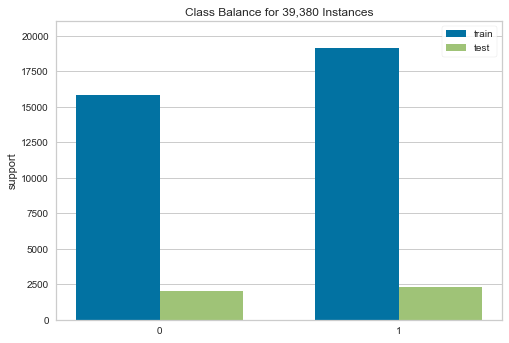

<AxesSubplot:title={'center':'Class Balance for 39,380 Instances'}, ylabel='support'>

In [19]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_train, y_val)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Modelling

Baseline Model - DummyClassifier ✔

==========================

Feature Selection 
- LASSO (prefered)
- RFE

==========================

- Logistics Regression
- KNN
- Gaussian (Naive Bayees)

- Decision Tree
- Random Forest

- LightGBM
- XGBoost
- AdsBoost


## Baseline Model - DummyClassifier

In [20]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train,y_train)

DummyClassifier()

Validation Result:

accuracy score: 0.5359



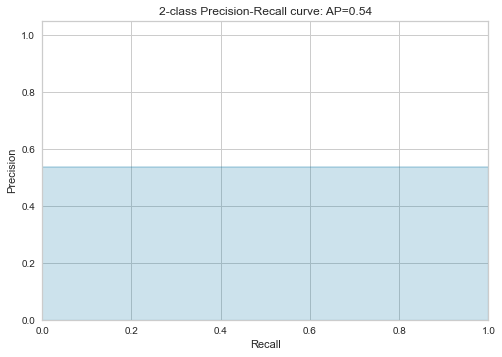

roc auc score: 0.5



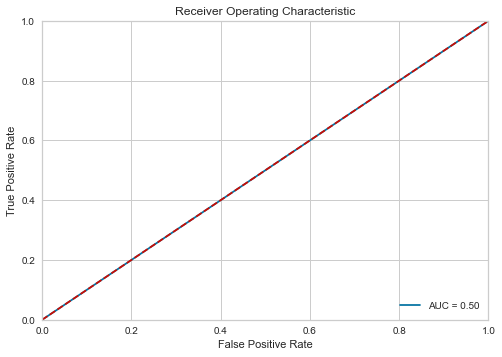

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2031
         1.0       0.54      1.00      0.70      2345

    accuracy                           0.54      4376
   macro avg       0.27      0.50      0.35      4376
weighted avg       0.29      0.54      0.37      4376


Confusion Matrix: 
 [[   0 2031]
 [   0 2345]]

End of validation Result



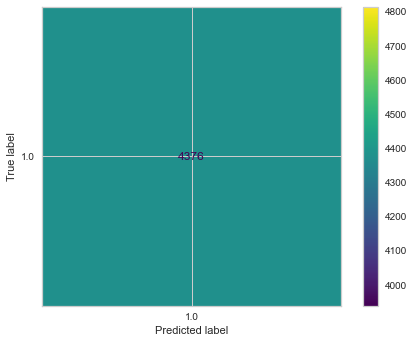

In [21]:
clf_score(dummy, X_train, y_train, X_val, y_val, train=False)

In [22]:
# Add result to model_comparison dataframe
model_name = 'DummyClassifier'
y_pred = dummy.predict(X_val)

add_result(model_name, y_val, y_pred)

                 precision  recall  f1-score support
DummyClassifier   0.535878     1.0  0.697813    2345


## Feature Selection

### 1. LASSO

In [23]:
lasso = Lasso(alpha=0.01)
model_lasso = lasso.fit(X_train, y_train)

In [24]:
model_lasso.coef_

array([ 0.00044513, -0.13973791,  0.01361016,  0.        , -0.00894538,
        0.        ,  0.00582552, -0.        ,  0.09717539,  0.03391091,
        0.0275149 ,  0.04385917,  0.03912013,  0.02210841,  0.03506695,
        0.01830838,  0.02908356, -0.00350892,  0.        ,  0.08976133,
        0.20718092])

In [25]:
pd.DataFrame(list(zip(X_train.columns,abs(model_lasso.coef_))), columns = ['predictor','coefficient']).sort_values(by='coefficient')

,predictor,coefficient
18,Gender_Male,0.000000
3,Inflight_wifi_service,0.000000
5,Ease_of_Online_booking,0.000000
7,Food_and_drink,0.000000
0,Age,0.000445
17,Departure_Delay_in_Minutes,0.003509
6,Gate_location,0.005826
4,Departure/Arrival_time_convenient,0.008945
2,Flight_Distance,0.013610
15,Inflight_service,0.018308


### 2. RFE

In [26]:
from sklearn.feature_selection import RFE

lr = LogisticRegression(max_iter=5000)
rfe = RFE(lr, n_features_to_select=3) 
model_rfe = rfe.fit(X_train,y_train)

In [27]:
model_rfe.support_

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True,  True])

In [28]:
pd.DataFrame(list(zip(X_train.columns,model_rfe.ranking_)), 
             columns = ['predictor','ranking']).sort_values(by='ranking')

,predictor,ranking
10,Inflight_entertainment,1
19,Customer_Type_Loyal Customer,1
20,Type_of_Travel_Business travel,1
8,Online_boarding,2
1,Class,3
13,Baggage_handling,4
14,Checkin_service,5
11,On-board_service,6
16,Cleanliness,7
9,Seat_comfort,8


Based on the above results, we can drop 'Gender_Male','Gate_location','Age', 'Food_and_drink'. 

In [29]:
X_train = X_train.drop(columns=['Gender_Male', 'Gate_location', 'Food_and_drink', 'Age'])
X_val = X_val.drop(columns=['Gender_Male', 'Gate_location', 'Food_and_drink', 'Age'])

## Random Forest

Validation Result:

accuracy score: 0.9758



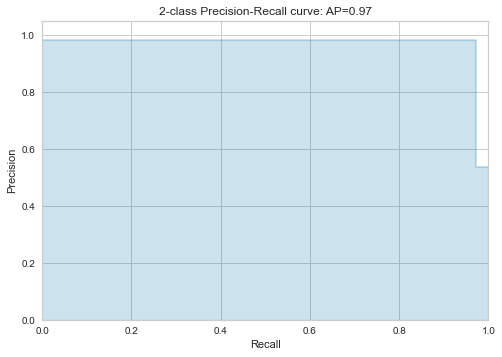

roc auc score: 0.9759812459122409



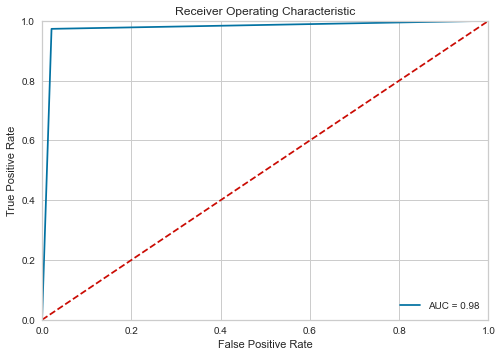

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2031
         1.0       0.98      0.97      0.98      2345

    accuracy                           0.98      4376
   macro avg       0.98      0.98      0.98      4376
weighted avg       0.98      0.98      0.98      4376


Confusion Matrix: 
 [[1988   43]
 [  63 2282]]

End of validation Result



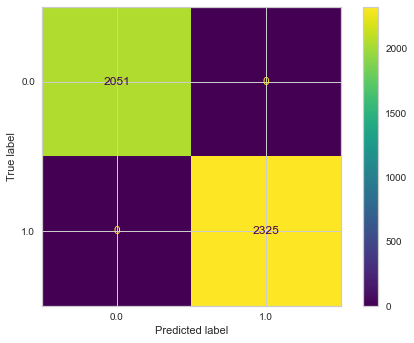

In [30]:
model_rf = RandomForestClassifier(n_estimators=2000, 
                                   max_features='sqrt',
                                   max_depth=35,
                                   bootstrap=False)
model_rf.fit(X_train,y_train)

clf_score(model_rf, X_train, y_train, X_val, y_val, train=False)

### Hyper-parameter tuning

In [46]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 35, 60, 85, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 650, 1100, 1550,
                                                         2000]},
                   random_state=42)

In [47]:
print(rf_random.best_params_)

{'n_estimators': 1100, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': False}


Validation Result:

accuracy score: 0.9753



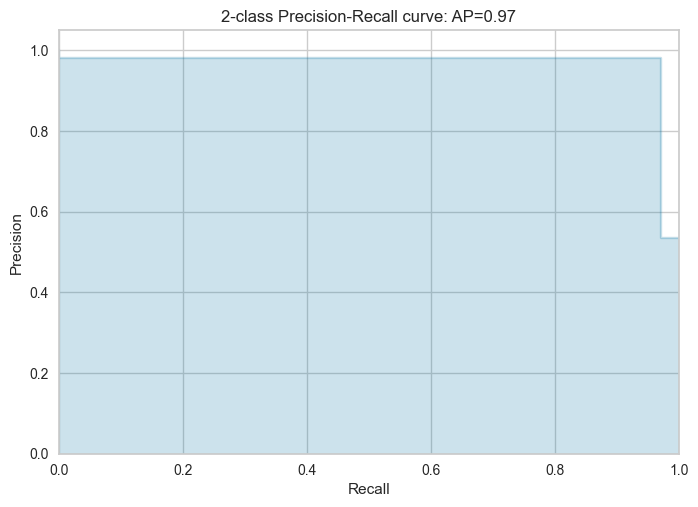

roc auc score: 0.9755548066798315



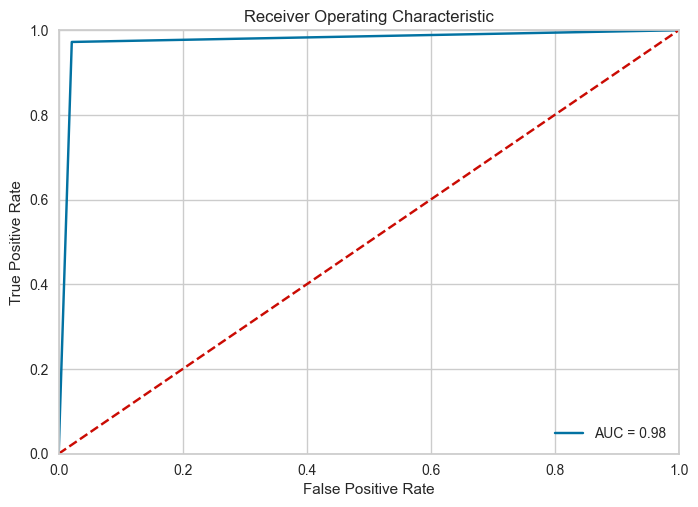

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2031
         1.0       0.98      0.97      0.98      2345

    accuracy                           0.98      4376
   macro avg       0.97      0.98      0.98      4376
weighted avg       0.98      0.98      0.98      4376


Confusion Matrix: 
 [[1988   43]
 [  65 2280]]

End of validation Result



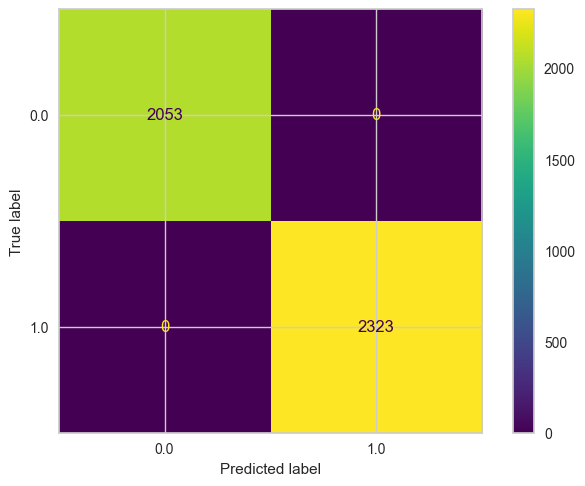

In [48]:
clf_score(rf_random, X_train, y_train, X_val, y_val, train=False)

In [49]:
# Add result to model_comparison dataframe
model_name = 'Random Forest'
y_pred = rf_random.predict(X_val)

add_result(model_name, y_val, y_pred)

                    precision    recall  f1-score support
DummyClassifier      0.535878  1.000000  0.697813    2345
LogisticRegression   0.933783  0.944136  0.938931    2345
KNN                  0.968830  0.967591  0.968210    2345
Naive Bayesian       0.940160  0.904478  0.921973    2345
Decision Tree        0.973493  0.971002  0.972246    2345
Random Forest        0.981489  0.972281  0.976864    2345


### Random Forest after Tune

Validation Result:

accuracy score: 0.9762



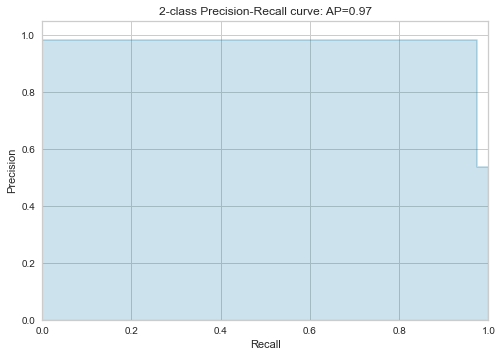

roc auc score: 0.9764076851446503



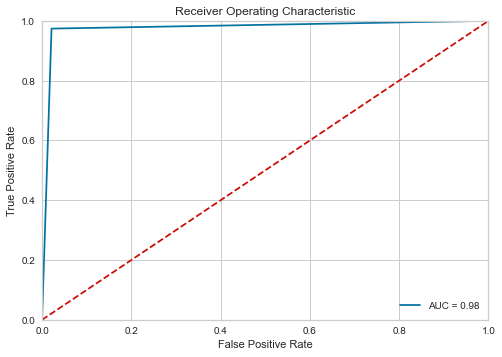

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2031
         1.0       0.98      0.97      0.98      2345

    accuracy                           0.98      4376
   macro avg       0.98      0.98      0.98      4376
weighted avg       0.98      0.98      0.98      4376


Confusion Matrix: 
 [[1988   43]
 [  61 2284]]

End of validation Result



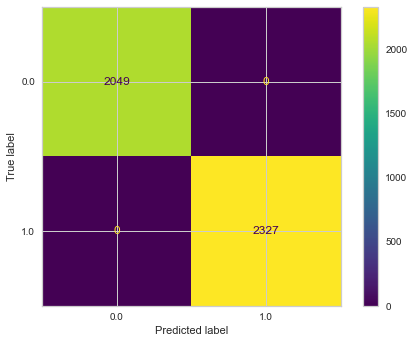

In [31]:
#{'n_estimators': 1100, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': False}

model_rf = RandomForestClassifier(n_estimators=1100, 
                                   max_features='auto',
                                   max_depth=60,
                                   bootstrap=False)
model_rf.fit(X_train,y_train)

clf_score(model_rf, X_train, y_train, X_val, y_val, train=False)

In [33]:
# Add result to model_comparison dataframe
model_name = 'Random Forest'

y_pred = model_rf.predict(X_val)

add_result(model_name, y_val, y_pred)

                 precision    recall  f1-score support
DummyClassifier   0.535878  1.000000  0.697813    2345
Random Forest     0.981521  0.973987  0.977740    2345


## LightGBM

In [50]:
lgbm_clf = LGBMClassifier(n_estimators=1000, 
                          n_jobs=1,
                          learning_rate=0.02,
                          num_leaves=50,
                          max_depth=7,
                          verbose=-1,
                          random_state=42)
model_lgbm= lgbm_clf.fit(X_train, y_train)

Validation Result:

accuracy score: 0.9774



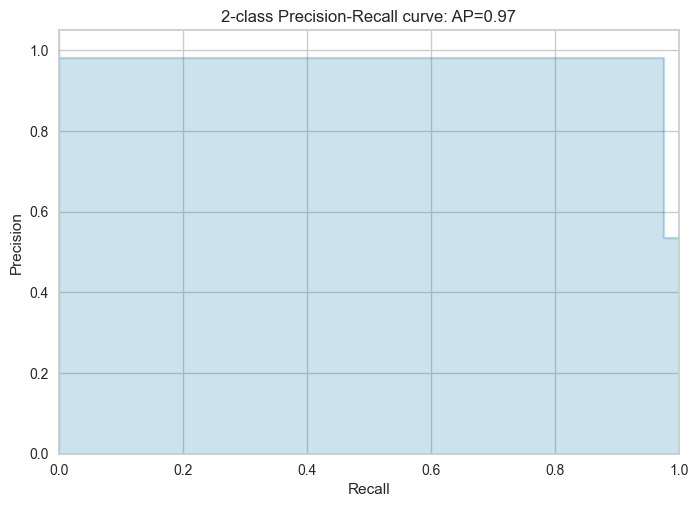

roc auc score: 0.9774408186961373



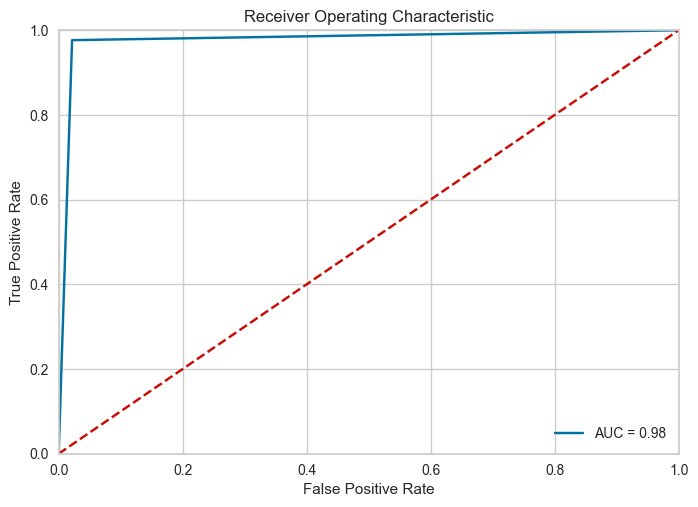

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      2031
         1.0       0.98      0.98      0.98      2345

    accuracy                           0.98      4376
   macro avg       0.98      0.98      0.98      4376
weighted avg       0.98      0.98      0.98      4376


Confusion Matrix: 
 [[1987   44]
 [  55 2290]]

End of validation Result



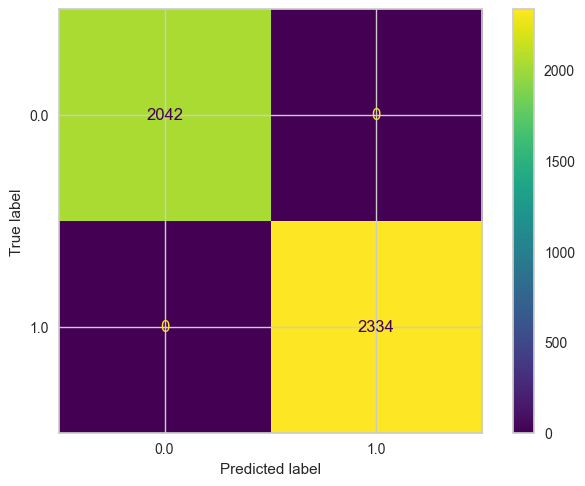

In [51]:
clf_score(model_lgbm, X_train, y_train, X_val, y_val, train=False)

In [52]:
# Add result to model_comparison dataframe
model_name = 'LightGBM'
y_pred = model_lgbm.predict(X_val)

add_result(model_name, y_val, y_pred)

                    precision    recall  f1-score support
DummyClassifier      0.535878  1.000000  0.697813    2345
LogisticRegression   0.933783  0.944136  0.938931    2345
KNN                  0.968830  0.967591  0.968210    2345
Naive Bayesian       0.940160  0.904478  0.921973    2345
Decision Tree        0.973493  0.971002  0.972246    2345
Random Forest        0.981489  0.972281  0.976864    2345
LightGBM             0.981148  0.976546  0.978842    2345


### Feature Importance - Random Forest

In [34]:
df_feature_importance = pd.DataFrame({'importance':model_rf.feature_importances_, 'feature': X_train.columns.values})
df_feature_importance.sort_values(by = 'importance', ascending=False)

,importance,feature
0,0.211213,Class
5,0.176051,Online_boarding
16,0.109874,Type_of_Travel_Business travel
7,0.094972,Inflight_entertainment
6,0.074106,Seat_comfort
9,0.044102,Leg_room_service
2,0.043658,Inflight_wifi_service
8,0.040860,On-board_service
1,0.040338,Flight_Distance
10,0.027502,Baggage_handling


In [30]:
#model_comparison.to_csv('model_comparison_2.csv')

# Evaluate model on test set

In [36]:
X_test.head()

,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,...,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
32587,-2.170426,2.0,-0.753406,2.0,3.0,2.0,3.0,4.0,2.0,4.0,...,2.0,3.0,3.0,3.0,4.0,4.0,-0.181262,0.0,0.0,1.0
6450,0.183299,2.0,-0.466678,2.0,4.0,4.0,4.0,2.0,2.0,2.0,...,3.0,4.0,3.0,3.0,4.0,2.0,7.356124,1.0,1.0,1.0
31754,0.790712,2.0,-0.480425,3.0,3.0,2.0,2.0,5.0,2.0,2.0,...,4.0,3.0,2.0,4.0,3.0,5.0,-0.455349,1.0,1.0,0.0
23512,1.094418,0.0,1.819291,3.0,3.0,4.0,3.0,2.0,5.0,5.0,...,4.0,4.0,4.0,4.0,4.0,5.0,4.341169,1.0,1.0,1.0
41840,-0.803747,2.0,-0.958633,1.0,5.0,1.0,3.0,2.0,1.0,2.0,...,4.0,3.0,4.0,5.0,4.0,2.0,3.930039,1.0,1.0,0.0


Now we test the model performance on the unseen test dataset.

In [37]:
print('before:', X_test.shape)
X_test = X_test.drop(columns=['Gender_Male', 'Gate_location', 'Food_and_drink', 'Age'])
print('after', X_test.shape)

before: (4376, 21)
after (4376, 17)


In [38]:
best_model = model_rf

#### Class Predictor Error

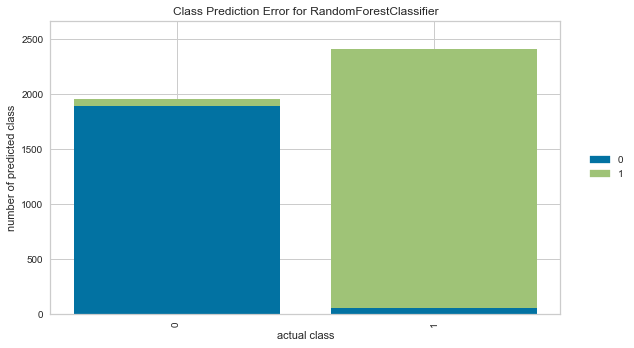

<AxesSubplot:title={'center':'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [39]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,5)

from yellowbrick.classifier import ClassPredictionError

classes = ["0", "1"]

visualizer = ClassPredictionError(
    best_model, classes=classes, is_fitted=True
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

#### Classification Report

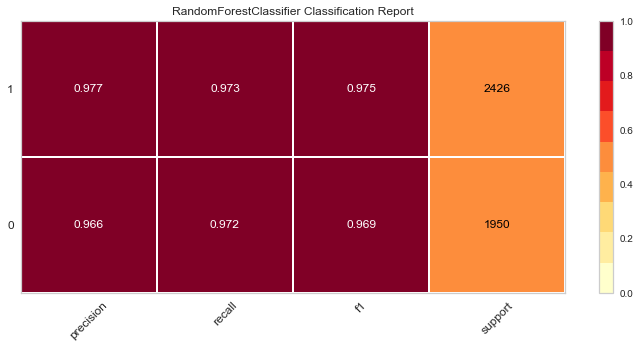

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [40]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(
    best_model, classes=classes, support=True, is_fitted=True
)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

#### Confusion Matrix

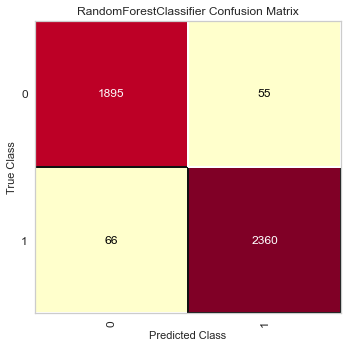

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [41]:
from yellowbrick.classifier import confusion_matrix, ConfusionMatrix
matplotlib.rcParams['figure.figsize'] = (5,5)

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(best_model, classes=[0,1], is_fitted=True)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

#### PR Curve

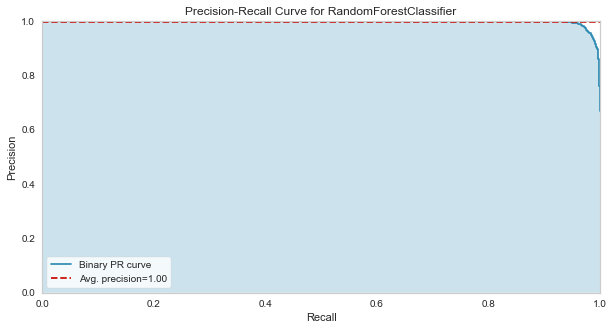

<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [42]:
from yellowbrick.classifier import PrecisionRecallCurve
matplotlib.rcParams['figure.figsize'] = (10,5)

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(best_model, is_fitted=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

#### ROC-AUC

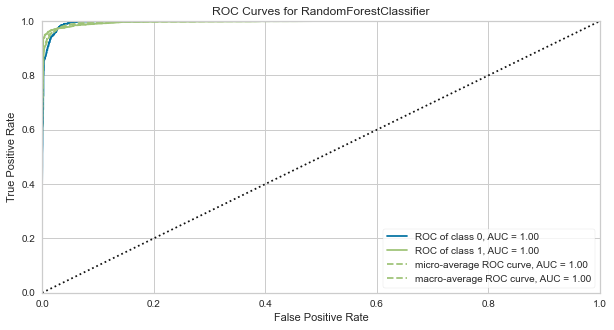

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [43]:
visualizer = ROCAUC(
    best_model, classes=classes, is_fitted=True
)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

#### Validation Curve

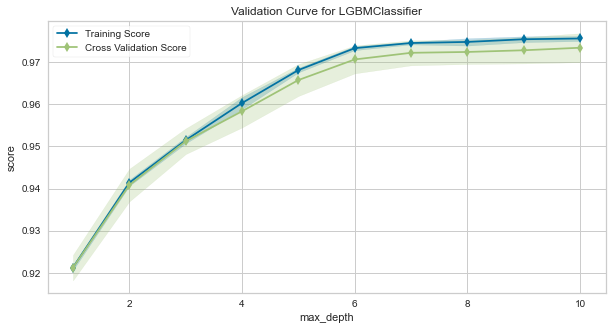

<AxesSubplot:title={'center':'Validation Curve for LGBMClassifier'}, xlabel='max_depth', ylabel='score'>

In [44]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    LGBMClassifier(n_estimators=40, random_state=42), 
    param_name="max_depth",
    param_range=np.arange(1, 11), 
    cv=5, 
    scoring="f1_weighted",
    np_jobs=8
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.poof()